<a href="https://colab.research.google.com/github/mukaseevru/ds-school/blob/main/final_project/word_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
import string
import umap
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option("display.max_colwidth", 200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Настройки

In [2]:
# Знаки пунктуации
stoppunct = string.punctuation + '—' + '«' + '»'
# stoppunct

In [3]:
stopwords = nltk.corpus.stopwords.words('russian')
add_stopwords = (['эта', 'этим', 'этими', 'этих', 'этому', 'ко', 'который', 'которого',
                  'которому', 'которым', 'котором', 'которая', 'которой',
                  'которую', 'такого', 'такому', 'таким', 'таком', 'такая',
                  'такую', 'которые', 'которых', 'которым', 'которыми', 'такие',
                  'таких', 'таким', 'такими', 'всем', 'всеми', 'самого',
                  'самому', 'самим', 'самом', 'сама', 'самой', 'саму', 'сами',
                  'самих', 'самим', 'самими', 'кого', 'кому', 'кем', 'ком',
                  'тому', 'та', 'той', 'ту', 'собой', 'моего', 'моему', 'моим',
                  'моем', 'моей', 'мою', 'оба', 'обе', 'с'])
stopwords.extend(add_stopwords)
stopwords.extend(stoppunct)
stopwords.append('')
stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [4]:
debug = True

# Функции

In [5]:
def is_number(s):
    '''
    Проверка на число. Возвращает True, если в полученной строке число
    '''
    try:
        float(s)
        return True
    except ValueError:
        return False

In [6]:
def short_words(text, stoppunct=stoppunct, stopwords=stopwords):
    '''
    Создание списка коротких слов
    '''
    if pd.isnull(text):
        return np.nan
    tokenizer = nltk.WordPunctTokenizer()
    words = [word.lower().strip(stoppunct) for word in tokenizer.tokenize(text)
             if word.lower().strip(stoppunct) not in stopwords]
    # удалить цифры
    words = [word for word in words if not (is_number(word))]
    short_words = []
    stemmer = nltk.stem.SnowballStemmer('russian')
    for word in words:
        short_words.append(stemmer.stem(word))
    return short_words

In [7]:
def count_words(words, stoppunct=stoppunct, stopwords=stopwords):
    '''
    Создание словаря с количеством слов
    '''
    if type(words) == np.float:
        return np.nan
    words_dict = {}
    for word in words:
        if word not in words_dict:
            words_dict[word] = 1
        else:
            words_dict[word] += 1
    return words_dict

In [8]:
def list_merge(lstlst, no_duplication=False):
    '''
    Объединение списков
    no_duplication - убирает дубликаты в одной статье. Для подсчета количества статей
    '''
    if type(lstlst) == np.float:
        return np.nan
    all = []
    for lst in lstlst:
        if type(lst) == np.float:
            continue
        if no_duplication:
            all.extend(set(lst))
        else:
            all.extend(lst)
    return all

In [9]:
union_dict = {}


def sum_dicts(d1, d2=union_dict):
    '''
    Сложение словарей
    '''
    k = set(list(d1.keys()) + list(d2.keys()))
    d = {}
    for i in k:
        v1 = d1.get(i)
        v2 = d2.get(i)
        if v1 == None:
            v = v2
        elif v2 == None:
            v = v1
        else:
            v = v1 + v2
        d[i] = v
    d2.update(d)
    # return d2

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
os.getcwd()

'/content'

In [12]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/sber/news/data/banki.csv',
                 dtype={'id': np.str,
                        'title': np.str,
                        'text': np.str,
                        'url': np.str,
                        'time': np.str,
                        'views': np.int64,
                        'comments': np.int64,
                        'source': np.str
                        })
df.time = pd.to_datetime(df.time, format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113250 entries, 0 to 113249
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        113250 non-null  object        
 1   title     113250 non-null  object        
 2   text      113172 non-null  object        
 3   url       113250 non-null  object        
 4   time      113250 non-null  datetime64[ns]
 5   views     113250 non-null  int64         
 6   comments  113250 non-null  int64         
 7   source    113211 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 6.9+ MB


In [13]:
df.head()

,id,title,text,url,time,views,comments,source
0,10940845,"Эксперты рассказали, каким образом мошенникам удается звонить с номеров госорганов и банков","На сегодняшний день телекоммуникационные системы позволяют проводить подмену номеров, что дает злоумышленникам, обладающим определенными навыками и техническими средствами, возможность звонить яко...",https://www.banki.ru/news/lenta/?id=10940845,2021-02-02 09:09:00,4268,0,Известия
1,10940844,Почти половина работников в России заявили о падении мотивации,"События 2020 года пагубно сказались на мотивации 49,4% сотрудников российских компаний, пишет РБК. Это выяснила в ходе опроса компания «Мегаплан». Почти 30% сотрудников и руководителей МСБ ответил...",https://www.banki.ru/news/lenta/?id=10940844,2021-02-02 08:58:00,2301,3,РБК
2,10940817,Банк « Уралсиб» сообщил о кадровых перестановках,"Станислав Тывес, заместитель председателя правления ПАО «Банк Уралсиб», возглавит блок розничного бизнеса банка. Станислав пришел в банк в 2018 году на должность заместителя председателя правления...",https://www.banki.ru/news/lenta/?id=10940817,2021-02-02 08:54:00,3239,0,Партнёрский материал
3,10940847,Опрос: москвичи не хотят возвращаться в офисы,"Более половины московских сотрудников, переведенных на дистанционную работу из-за пандемии коронавируса, хотели бы остаться на «удаленке» навсегда. Таковы результаты опроса сервиса SuperJob.По сос...",https://www.banki.ru/news/lenta/?id=10940847,2021-02-02 08:49:00,2234,4,Banki.ru
4,10940843,"В России число преступлений с банковскими картами выросло в 5,5 раза","В России в 2020 году количество преступлений с использованием банковских карт достигло 190,2 тыс., что в пять с половиной раз больше показателей предыдущего года, пишут «Известия». Об этом сообщае...",https://www.banki.ru/news/lenta/?id=10940843,2021-02-02 08:48:00,2631,2,Известия


Создадим столбцы:
1. Будут содержать список слов, из которых состоят заголовки и текст.
2. Будут содержать список словарей со словами и количеством вхождений этих слов в заголовках и текстах.

In [14]:
df['title_words'] = df.title.apply(
    lambda title: short_words(title, stoppunct, stopwords))
df['text_words'] = df.text.apply(
    lambda text: short_words(text, stoppunct, stopwords))
df['count_title_words'] = df.title_words.apply(
    lambda words: count_words(words, stoppunct, stopwords))
df['count_text_words'] = df.text_words.apply(
    lambda words: count_words(words, stoppunct, stopwords))

In [15]:
df.head()

,id,title,text,url,time,views,comments,source,title_words,text_words,count_title_words,count_text_words
0,10940845,"Эксперты рассказали, каким образом мошенникам удается звонить с номеров госорганов и банков","На сегодняшний день телекоммуникационные системы позволяют проводить подмену номеров, что дает злоумышленникам, обладающим определенными навыками и техническими средствами, возможность звонить яко...",https://www.banki.ru/news/lenta/?id=10940845,2021-02-02 09:09:00,4268,0,Известия,"[эксперт, рассказа, как, образ, мошенник, уда, звон, номер, госорган, банк]","[сегодняшн, ден, телекоммуникацион, систем, позволя, провод, подмен, номер, дает, злоумышленник, облада, определен, навык, техническ, средств, возможн, звон, якоб, номер, госорган, банк, пишут, из...","{'эксперт': 1, 'рассказа': 1, 'как': 1, 'образ': 1, 'мошенник': 1, 'уда': 1, 'звон': 1, 'номер': 1, 'госорган': 1, 'банк': 1}","{'сегодняшн': 1, 'ден': 1, 'телекоммуникацион': 1, 'систем': 2, 'позволя': 3, 'провод': 2, 'подмен': 2, 'номер': 11, 'дает': 1, 'злоумышленник': 2, 'облада': 1, 'определен': 1, 'навык': 2, 'технич..."
1,10940844,Почти половина работников в России заявили о падении мотивации,"События 2020 года пагубно сказались на мотивации 49,4% сотрудников российских компаний, пишет РБК. Это выяснила в ходе опроса компания «Мегаплан». Почти 30% сотрудников и руководителей МСБ ответил...",https://www.banki.ru/news/lenta/?id=10940844,2021-02-02 08:58:00,2301,3,РБК,"[половин, работник, росс, заяв, паден, мотивац]","[событ, год, пагубн, сказа, мотивац, сотрудник, российск, компан, пишет, рбк, эт, выясн, ход, опрос, компан, мегапла, сотрудник, руководител, мсб, ответ, прошедш, год, никак, сказа, трудоспособн, ...","{'половин': 1, 'работник': 1, 'росс': 1, 'заяв': 1, 'паден': 1, 'мотивац': 1}","{'событ': 1, 'год': 3, 'пагубн': 1, 'сказа': 4, 'мотивац': 2, 'сотрудник': 5, 'российск': 1, 'компан': 5, 'пишет': 1, 'рбк': 1, 'эт': 2, 'выясн': 1, 'ход': 1, 'опрос': 1, 'мегапла': 2, 'руководите..."
2,10940817,Банк « Уралсиб» сообщил о кадровых перестановках,"Станислав Тывес, заместитель председателя правления ПАО «Банк Уралсиб», возглавит блок розничного бизнеса банка. Станислав пришел в банк в 2018 году на должность заместителя председателя правления...",https://www.banki.ru/news/lenta/?id=10940817,2021-02-02 08:54:00,3239,0,Партнёрский материал,"[банк, уралсиб, сообщ, кадров, перестановк]","[станисла, тывес, заместител, председател, правлен, па, банк, уралсиб, возглав, блок, розничн, бизнес, банк, станисла, пришел, банк, год, должност, заместител, председател, правлен, руководител, с...","{'банк': 1, 'уралсиб': 1, 'сообщ': 1, 'кадров': 1, 'перестановк': 1}","{'станисла': 3, 'тывес': 1, 'заместител': 2, 'председател': 2, 'правлен': 2, 'па': 1, 'банк': 6, 'уралсиб': 1, 'возглав': 2, 'блок': 2, 'розничн': 4, 'бизнес': 6, 'пришел': 1, 'год': 7, 'должност'..."
3,10940847,Опрос: москвичи не хотят возвращаться в офисы,"Более половины московских сотрудников, переведенных на дистанционную работу из-за пандемии коронавируса, хотели бы остаться на «удаленке» навсегда. Таковы результаты опроса сервиса SuperJob.По сос...",https://www.banki.ru/news/lenta/?id=10940847,2021-02-02 08:49:00,2234,4,Banki.ru,"[опрос, москвич, хот, возвраща, офис]","[половин, московск, сотрудник, переведен, дистанцион, работ, пандем, коронавирус, хотел, оста, удаленк, навсегд, таков, результат, опрос, сервис, superjob, состоян, конец, январ, кажд, трет, столи...","{'опрос': 1, 'москвич': 1, 'хот': 1, 'возвраща': 1, 'офис': 1}","{'половин': 1, 'московск': 1, 'сотрудник': 3, 'переведен': 2, 'дистанцион': 5, 'работ': 3, 'пандем': 2, 'коронавирус': 1, 'хотел': 1, 'оста': 2, 'удаленк': 5, 'навсегд': 2, 'таков': 1, 'результат'..."
4,10940843,"В России число преступлений с банковскими картами выросло в 5,5 раза","В России в 2020 году количество преступлений с использованием банковских карт достигло 190,2 тыс., что в пять с половиной раз больше показателей предыдущего года, пишут «Известия». Об этом сообщае...",htt

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113250 entries, 0 to 113249
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 113250 non-null  object        
 1   title              113250 non-null  object        
 2   text               113172 non-null  object        
 3   url                113250 non-null  object        
 4   time               113250 non-null  datetime64[ns]
 5   views              113250 non-null  int64         
 6   comments           113250 non-null  int64         
 7   source             113211 non-null  object        
 8   title_words        113250 non-null  object        
 9   text_words         113172 non-null  object        
 10  count_title_words  113250 non-null  object        
 11  count_text_words   113172 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 10.4+ MB


In [17]:
df.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/news_withwords.csv', index=False)

# Аналитика по дням

## Titles

Сделаем аналитику по заголовкам

In [18]:
# Слова
titles = {}
for i in range(1, df.time.dt.dayofyear.max()+1):
    titles[i] = pd.Series(count_words(list_merge(df[(df.time.dt.dayofyear == i) &
                                                    (df.time.dt.isocalendar().year == 2020)].title_words)))
titles_daily = pd.concat(titles, axis=1)
columns = titles_daily.columns
titles_daily['sum_yearly'] = titles_daily[columns].sum(axis=1)
titles_daily['mean_yearly'] = titles_daily[columns].mean(axis=1)
titles_daily['median_yearly'] = titles_daily[columns].median(axis=1)
titles_daily[['sum_yearly', 'mean_yearly', 'median_yearly']].head(10)

# Новости
titles = {}
for i in range(1, df.time.dt.dayofyear.max()+1):
    titles[i] = pd.Series(count_words(list_merge(df[(df.time.dt.dayofyear == i) &
                                                    (df.time.dt.isocalendar().year == 2020)].title_words, no_duplication=True)))
titles_daily_n = pd.concat(titles, axis=1)
columns = titles_daily_n.columns
titles_daily_n['sum_yearly'] = titles_daily_n[columns].sum(axis=1)
titles_daily_n['mean_yearly'] = titles_daily_n[columns].mean(axis=1)
titles_daily_n['median_yearly'] = titles_daily_n[columns].median(axis=1)
titles_daily_n[['sum_yearly', 'mean_yearly', 'median_yearly']].head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launche

,sum_yearly,mean_yearly,median_yearly
исследован,212.0,1.394737,1.0
закредитова,3.0,1.000000,1.0
явля,8.0,1.000000,1.0
лет,171.0,1.346457,1.0
россиян,249.0,1.596154,1.0
сам,92.0,1.260274,1.0
заемщик,100.0,1.204819,1.0
валютн,359.0,1.534188,1.0
заверш,321.0,1.793296,2.0
укреплен,64.0,1.084746,1.0


In [19]:
titles_daily.sort_index(inplace=True)
titles_daily_n.sort_index(inplace=True)

In [20]:
titles_daily.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/titles_daily.csv')
titles_daily_n.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/titles_daily_n.csv')

## Texts

Сделаем аналитику по текстам

In [21]:
# Слова
texts = {}
for i in range(1, df.time.dt.dayofyear.max()+1):
    texts[i] = pd.Series(count_words(list_merge(df[(df.time.dt.dayofyear == i) &
                                                   (df.time.dt.isocalendar().year == 2020)].text_words)))
texts_daily = pd.concat(texts, axis=1)
columns = texts_daily.columns
texts_daily['sum'] = texts_daily[columns].sum(axis=1)
texts_daily['mean'] = texts_daily[columns].mean(axis=1)
texts_daily['median'] = texts_daily[columns].median(axis=1)
texts_daily[['sum', 'mean', 'median']].head(10)

# Новости
texts = {}
for i in range(1, df.time.dt.dayofyear.max()+1):
    texts[i] = pd.Series(count_words(list_merge(df[(df.time.dt.dayofyear == i) &
                                                   (df.time.dt.isocalendar().year == 2020)].text_words, no_duplication=True)))
texts_daily_n = pd.concat(texts, axis=1)
columns = texts_daily_n.columns
texts_daily_n['sum'] = texts_daily_n[columns].sum(axis=1)
texts_daily_n['mean'] = texts_daily_n[columns].mean(axis=1)
texts_daily_n['median'] = texts_daily_n[columns].median(axis=1)
texts_daily_n[['sum', 'mean', 'median']].head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launche

,sum,mean,median
год,10409.0,29.997118,36.0
возрастн,62.0,1.148148,1.0
абсолютн,324.0,1.732620,1.0
заемщик,1146.0,3.720779,3.0
нараст,133.0,1.316832,1.0
обраща,521.0,2.207627,2.0
повышен,1776.0,5.550000,5.0
нужн,1456.0,4.507740,4.0
ипотек,997.0,3.426117,3.0
связа,1979.0,6.552980,6.0


In [22]:
texts_daily.sort_index(inplace=True)
texts_daily_n.sort_index(inplace=True)

In [23]:
texts_daily.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/texts_daily.csv')
texts_daily_n.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/texts_daily_n.csv')

# Аналитика по неделям

## Titles

### Fullweek

Аналитика по заголовкам. Объединяем по полным неделям.

In [24]:
# Слова
titles = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    titles[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                    (df.time.dt.isocalendar().year == 2020)].title_words)))
titles_weekly = pd.concat(titles, axis=1)
columns = titles_weekly.columns
titles_weekly['sum_weekly'] = titles_weekly[columns].sum(axis=1)
titles_weekly['mean_weekly'] = titles_weekly[columns].mean(axis=1)
titles_weekly['median_weekly'] = titles_weekly[columns].median(axis=1)
titles_weekly[['sum_weekly', 'mean_weekly', 'median_weekly']].head(10)

# Новости
titles = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    titles[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                    (df.time.dt.isocalendar().year == 2020)].title_words, no_duplication=True)))
titles_weekly_n = pd.concat(titles, axis=1)
columns = titles_weekly_n.columns
titles_weekly_n['sum_weekly'] = titles_weekly_n[columns].sum(axis=1)
titles_weekly_n['mean_weekly'] = titles_weekly_n[columns].mean(axis=1)
titles_weekly_n['median_weekly'] = titles_weekly_n[columns].median(axis=1)
titles_weekly_n[['sum_weekly', 'mean_weekly', 'median_weekly']].head(10)

,sum_weekly,mean_weekly,median_weekly
стандарт,69.0,1.971429,2.0
держател,40.0,1.428571,1.0
кешбэк,85.0,2.073171,1.0
предлож,464.0,8.754717,8.0
повышен,145.0,2.959184,2.0
русск,59.0,1.735294,1.5
карт,488.0,9.207547,9.0
банк,3075.0,58.018868,58.0
нов,683.0,12.886792,13.0
категор,24.0,1.263158,1.0


### Workdays

 Аналитика по заголовкам. Объединяем по рабочим дням недели.

In [25]:
# Слова
titles = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    titles[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                    (df.time.dt.isocalendar().day >= 1) &
                                                    (df.time.dt.isocalendar().day <= 5) &
                                                    (df.time.dt.isocalendar().year == 2020)].title_words)))
titles_weekly_workdays = pd.concat(titles, axis=1)
columns = titles_weekly_workdays.columns
titles_weekly_workdays['sum_weekly_workdays'] = titles_weekly_workdays[columns].sum(
    axis=1)
titles_weekly_workdays['mean_weekly_workdays'] = titles_weekly_workdays[columns].mean(
    axis=1)
titles_weekly_workdays['median_weekly_workdays'] = titles_weekly_workdays[columns].median(
    axis=1)
titles_weekly_workdays[['sum_weekly_workdays',
                        'mean_weekly_workdays', 'median_weekly_workdays']].head(10)

# Новости
titles = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    titles[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                    (df.time.dt.isocalendar().day >= 1) &
                                                    (df.time.dt.isocalendar().day <= 5) &
                                                    (df.time.dt.isocalendar().year == 2020)].title_words, no_duplication=True)))
titles_weekly_workdays_n = pd.concat(titles, axis=1)
columns = titles_weekly_workdays_n.columns
titles_weekly_workdays_n['sum_weekly_workdays'] = titles_weekly_workdays_n[columns].sum(
    axis=1)
titles_weekly_workdays_n['mean_weekly_workdays'] = titles_weekly_workdays_n[columns].mean(
    axis=1)
titles_weekly_workdays_n['median_weekly_workdays'] = titles_weekly_workdays_n[columns].median(
    axis=1)
titles_weekly_workdays_n[['sum_weekly_workdays',
                          'mean_weekly_workdays', 'median_weekly_workdays']].head(10)

,sum_weekly_workdays,mean_weekly_workdays,median_weekly_workdays
стандарт,61.0,1.848485,2.0
держател,31.0,1.240000,1.0
кешбэк,70.0,1.944444,1.5
предлож,453.0,8.547170,8.0
повышен,138.0,2.816327,2.0
русск,52.0,1.625000,1.0
карт,386.0,7.283019,7.0
банк,2817.0,53.150943,52.0
нов,624.0,11.773585,12.0
категор,21.0,1.235294,1.0


### Weekend

Аналитика по заголовкам. Объединяем по выходным дням недели.

In [26]:
# Слова
titles = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    titles[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                    (df.time.dt.isocalendar().day >= 6) &
                                                    (df.time.dt.isocalendar().day <= 7) &
                                                    (df.time.dt.isocalendar().year == 2020)].title_words)))
titles_weekly_weekend = pd.concat(titles, axis=1)
columns = titles_weekly_weekend.columns
titles_weekly_weekend['sum_weekly_weekend'] = titles_weekly_weekend[columns].sum(
    axis=1)
titles_weekly_weekend['mean_weekly_weekend'] = titles_weekly_weekend[columns].mean(
    axis=1)
titles_weekly_weekend['median_weekly_weekend'] = titles_weekly_weekend[columns].median(
    axis=1)
titles_weekly_weekend[['sum_weekly_weekend',
                       'mean_weekly_weekend', 'median_weekly_weekend']].head(10)

# Новости
titles = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    titles[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                    (df.time.dt.isocalendar().day >= 6) &
                                                    (df.time.dt.isocalendar().day <= 7) &
                                                    (df.time.dt.isocalendar().year == 2020)].title_words, no_duplication=True)))
titles_weekly_weekend_n = pd.concat(titles, axis=1)
columns = titles_weekly_weekend_n.columns
titles_weekly_weekend_n['sum_weekly_weekend'] = titles_weekly_weekend_n[columns].sum(
    axis=1)
titles_weekly_weekend_n['mean_weekly_weekend'] = titles_weekly_weekend_n[columns].mean(
    axis=1)
titles_weekly_weekend_n['median_weekly_weekend'] = titles_weekly_weekend_n[columns].median(
    axis=1)
titles_weekly_weekend_n[['sum_weekly_weekend',
                         'mean_weekly_weekend', 'median_weekly_weekend']].head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,sum_weekly_weekend,mean_weekly_weekend,median_weekly_weekend
сниз,36.0,1.333333,1.0
торг,36.0,1.000000,1.0
нефт,53.0,1.358974,1.0
цен,51.0,1.275000,1.0
пятниц,38.0,1.000000,1.0
итог,36.0,1.028571,1.0
миров,46.0,1.179487,1.0
инвестор,8.0,1.142857,1.0
дивиденд,3.0,1.000000,1.0
долг,11.0,1.222222,1.0


In [27]:
titles_words = pd.concat([titles_daily, titles_weekly,
                          titles_weekly_weekend, titles_weekly_workdays], axis=1).fillna(0)
titles_words_n = pd.concat([titles_daily_n, titles_weekly_n,
                            titles_weekly_weekend_n, titles_weekly_workdays_n], axis=1).fillna(0)

In [28]:
titles_words.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/titles_words.csv')
titles_words_n.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/titles_words_n.csv')

## Texts

### Fullweek

Аналитика по текстам. Объединяем по полным неделям.

In [29]:
# Слова
texts = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    texts[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                   (df.time.dt.isocalendar().year == 2020)].text_words)))
texts_weekly = pd.concat(texts, axis=1)
columns = texts_weekly.columns
texts_weekly['sum_weekly'] = texts_weekly[columns].sum(axis=1)
texts_weekly['mean_weekly'] = texts_weekly[columns].mean(axis=1)
texts_weekly['median_weekly'] = texts_weekly[columns].median(axis=1)
texts_weekly[['sum_weekly', 'mean_weekly', 'median_weekly']].head(10)

# Новости
texts = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    texts[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                   (df.time.dt.isocalendar().year == 2020)].text_words, no_duplication=True)))
texts_weekly_n = pd.concat(texts, axis=1)
columns = texts_weekly_n.columns
texts_weekly_n['sum_weekly'] = texts_weekly_n[columns].sum(axis=1)
texts_weekly_n['mean_weekly'] = texts_weekly_n[columns].mean(axis=1)
texts_weekly_n['median_weekly'] = texts_weekly_n[columns].median(axis=1)
texts_weekly_n[['sum_weekly', 'mean_weekly', 'median_weekly']].head(10)

,sum_weekly,mean_weekly,median_weekly
год,10409.0,196.396226,203.0
квартал,940.0,17.735849,16.0
подключен,347.0,6.547170,6.0
стандарт,415.0,7.830189,8.0
азс,74.0,2.055556,2.0
получен,1716.0,32.377358,32.0
rs,6.0,1.500000,1.5
рестора,148.0,3.083333,2.5
банк,8445.0,159.339623,162.0
участв,150.0,3.191489,3.0


### Workdays

 Аналитика по текстам. Объединяем по рабочим дням недели.

In [30]:
# Слова
texts = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    texts[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                   (df.time.dt.isocalendar().day >= 1) &
                                                   (df.time.dt.isocalendar().day <= 5) &
                                                   (df.time.dt.isocalendar().year == 2020)].text_words)))
texts_weekly_workdays = pd.concat(texts, axis=1)
columns = texts_weekly_workdays.columns
texts_weekly_workdays['sum_weekly_workdays'] = texts_weekly_workdays[columns].sum(
    axis=1)
texts_weekly_workdays['mean_weekly_workdays'] = texts_weekly_workdays[columns].mean(
    axis=1)
texts_weekly_workdays['median_weekly_workdays'] = texts_weekly_workdays[columns].median(
    axis=1)
texts_weekly_workdays[['sum_weekly_workdays',
                       'mean_weekly_workdays', 'median_weekly_workdays']].head(10)

# Новости
texts = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    texts[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                   (df.time.dt.isocalendar().day >= 1) &
                                                   (df.time.dt.isocalendar().day <= 5) &
                                                   (df.time.dt.isocalendar().year == 2020)].text_words, no_duplication=True)))
texts_weekly_workdays_n = pd.concat(texts, axis=1)
columns = texts_weekly_workdays_n.columns
texts_weekly_workdays_n['sum_weekly_workdays'] = texts_weekly_workdays_n[columns].sum(
    axis=1)
texts_weekly_workdays_n['mean_weekly_workdays'] = texts_weekly_workdays_n[columns].mean(
    axis=1)
texts_weekly_workdays_n['median_weekly_workdays'] = texts_weekly_workdays_n[columns].median(
    axis=1)
texts_weekly_workdays_n[['sum_weekly_workdays',
                         'mean_weekly_workdays', 'median_weekly_workdays']].head(10)

,sum_weekly_workdays,mean_weekly_workdays,median_weekly_workdays
год,9849.0,185.830189,192.0
квартал,903.0,17.037736,16.0
подключен,297.0,5.603774,6.0
стандарт,358.0,6.754717,7.0
азс,57.0,1.628571,1.0
получен,1588.0,29.962264,31.0
rs,5.0,1.250000,1.0
рестора,125.0,2.717391,2.0
банк,7779.0,146.773585,151.0
участв,139.0,3.021739,3.0


### Weekend

Аналитика по текстам. Объединяем по выходным дням недели.

In [31]:
# Слова
texts = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    texts[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                   (df.time.dt.isocalendar().day >= 6) &
                                                   (df.time.dt.isocalendar().day <= 7) &
                                                   (df.time.dt.isocalendar().year == 2020)].text_words)))
texts_weekly_weekend = pd.concat(texts, axis=1)
columns = texts_weekly_weekend.columns
texts_weekly_weekend['sum_weekly_weekend'] = texts_weekly_weekend[columns].sum(
    axis=1)
texts_weekly_weekend['mean_weekly_weekend'] = texts_weekly_weekend[columns].mean(
    axis=1)
texts_weekly_weekend['median_weekly_weekend'] = texts_weekly_weekend[columns].median(
    axis=1)
texts_weekly_weekend[['sum_weekly_weekend',
                      'mean_weekly_weekend', 'median_weekly_weekend']].head(10)

# Новости
texts = {}
for i in range(1, df.time.dt.isocalendar().week.max()+1):
    texts[i] = pd.Series(count_words(list_merge(df[(df.time.dt.isocalendar().week == i) &
                                                   (df.time.dt.isocalendar().day >= 6) &
                                                   (df.time.dt.isocalendar().day <= 7) &
                                                   (df.time.dt.isocalendar().year == 2020)].text_words, no_duplication=True)))
texts_weekly_weekend_n = pd.concat(texts, axis=1)
columns = texts_weekly_weekend_n.columns
texts_weekly_weekend_n['sum_weekly_weekend'] = texts_weekly_weekend_n[columns].sum(
    axis=1)
texts_weekly_weekend_n['mean_weekly_weekend'] = texts_weekly_weekend_n[columns].mean(
    axis=1)
texts_weekly_weekend_n['median_weekly_weekend'] = texts_weekly_weekend_n[columns].median(
    axis=1)
texts_weekly_weekend_n[['sum_weekly_weekend',
                        'mean_weekly_weekend', 'median_weekly_weekend']].head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,sum_weekly_weekend,mean_weekly_weekend,median_weekly_weekend
баррел,60.0,1.463415,1.0
европ,52.0,1.333333,1.0
бирж,60.0,1.500000,1.0
уменьш,62.0,1.722222,1.0
состав,247.0,4.940000,5.0
котировк,42.0,1.076923,1.0
февральск,7.0,1.000000,1.0
торг,53.0,1.358974,1.0
сделок,52.0,1.238095,1.0
стоимост,148.0,3.148936,3.0


In [32]:
texts_words = pd.concat([texts_daily, texts_weekly,
                         texts_weekly_weekend, texts_weekly_workdays], axis=1).fillna(0)
texts_words_n = pd.concat([texts_daily_n, texts_weekly_n,
                           texts_weekly_weekend_n, texts_weekly_workdays_n], axis=1).fillna(0)

In [33]:
import gc
gc.collect()

12

Сохраним аналитику в отдельные файлы.

In [34]:
texts_words.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/texts_words.csv')
texts_words_n.to_csv(
    'drive/MyDrive/Colab Notebooks/sber/news/data/texts_words_n.csv')

# Визуализация

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'Годы')

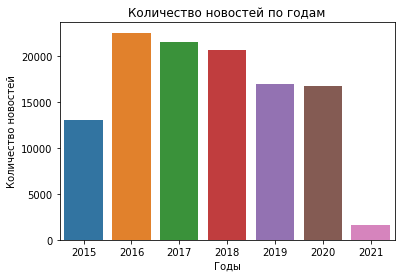

In [36]:
ax = sns.countplot(x=df.time.sort_values().dt.strftime('%Y'), data=df)
ax.set_title('Количество новостей по годам')
ax.set_ylabel('Количество новостей')
ax.set_xlabel('Годы')

Text(0.5, 0, 'Месяцы')

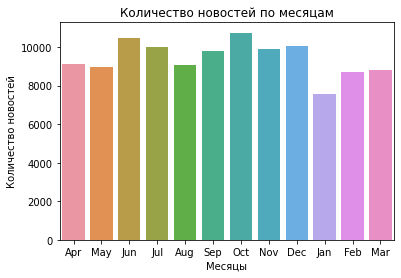

In [37]:
ax = sns.countplot(x=df.time.sort_values().dt.strftime('%b'), data=df)
ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество новостей')
ax.set_xlabel('Месяцы')

Text(0.5, 0, 'Часы')

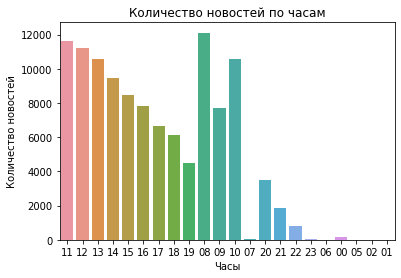

In [38]:
ax = sns.countplot(x=df.time.sort_values().dt.strftime('%H'), data=df)
ax.set_title('Количество новостей по часам')
ax.set_ylabel('Количество новостей')
ax.set_xlabel('Часы')

Text(0.5, 0, 'Дни недели')

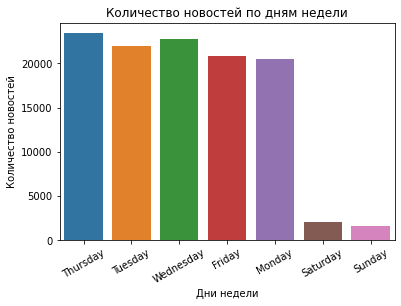

In [39]:
ax = sns.countplot(x=df.time.sort_values().dt.strftime('%A'), data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title('Количество новостей по дням недели')
ax.set_ylabel('Количество новостей')
ax.set_xlabel('Дни недели')

Text(0.5, 0, 'Ресурсы')

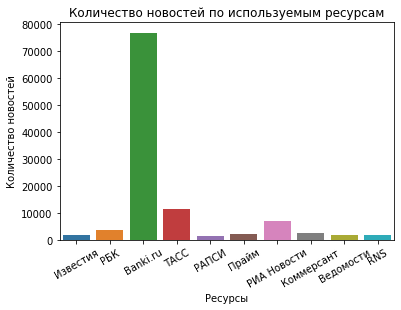

In [40]:
# Топ-10 ресурсов
ax = sns.countplot(
    x=df[df.source.isin(df.source.value_counts()[:10].index)].source, data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_title('Количество новостей по используемым ресурсам')
ax.set_ylabel('Количество новостей')
ax.set_xlabel('Ресурсы')

# LSA

In [41]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


def load_data(path, file_name):
    '''
    Функция загрузки данных
    '''
    documents_list = []
    titles = []
    with open(os.path.join(path, file_name), "r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:", len(documents_list))
    titles.append(text[0:min(len(text), 100)])
    return documents_list, titles


def preprocess_data(doc_set):
    '''
    Функция предобработки текста
    '''
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    # en_stop = set(stopwords.words('english'))
    en_stop = set(stopwords)
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


def prepare_corpus(doc_clean):
    '''
    Функция создания корпуса текста
    '''
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix


def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    '''
    Создание LSA модели
    '''
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(
        doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    '''
    Вычисление значения coherence_values
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics,
                         id2word=dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


def plot_graph(doc_clean, start, stop, step):
    '''
    Функция построения графика
    '''
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.title('График coherence score')
    plt.xlabel('Количество новостей')
    plt.ylabel('Coherence score')
    plt.legend(('coherence_values'), loc='best')
    plt.show()


number_of_topics = 10
words = 5
clean_text = preprocess_data(df.title.to_list())
model = create_gensim_lsa_model(clean_text, number_of_topics, words)

[(0, '0.691*"банк" + 0.401*"ставки" + 0.261*"рублей" + 0.252*"вкладам" + 0.209*"млрд"'), (1, '0.469*"рублей" + 0.366*"млрд" + -0.312*"банк" + 0.304*"доллара" + 0.296*"курс"'), (2, '-0.423*"доллара" + 0.402*"рублей" + -0.400*"курс" + 0.358*"млрд" + -0.289*"евро"'), (3, '0.500*"цб" + 0.413*"торги" + 0.385*"рф" + 0.271*"фондовые" + 0.239*"россии"'), (4, '-0.533*"банк" + 0.513*"ставки" + 0.413*"цб" + 0.356*"вкладам" + 0.175*"рублях"'), (5, '0.669*"цб" + -0.370*"торги" + -0.255*"рф" + -0.239*"фондовые" + -0.183*"ставки"'), (6, '0.416*"евро" + 0.316*"итогам" + 0.295*"торгов" + -0.257*"30" + -0.255*"11"'), (7, '0.781*"россии" + 0.232*"году" + 0.170*"1" + -0.160*"цб" + -0.147*"рублей"'), (8, '-0.358*"евро" + 0.355*"нефть" + 0.335*"цены" + 0.323*"торгов" + 0.315*"мировые"'), (9, '-0.743*"банка" + 0.265*"рф" + -0.239*"россии" + 0.237*"млрд" + -0.205*"млн"')]


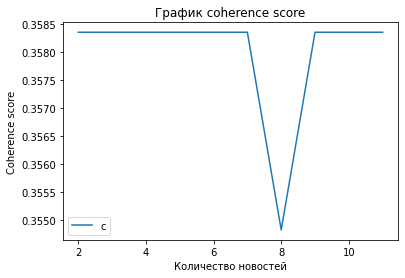

In [42]:
start, stop, step = 2, 12, 1
plot_graph(clean_text, start, stop, step)

# SVD

## Titles

In [62]:
news_df = pd.DataFrame({'title': df.title.values,
                        'text': df.text.values})

news_df.dropna(inplace=True)

# removing everything except alphabets`
news_df['clean_title'] = news_df['title'].str.replace('[^а-яА-Я#]', ' ')
news_df['clean_text'] = news_df['text'].str.replace('[^а-яА-Я#]', ' ')

# removing short words
news_df['clean_title'] = news_df['clean_title'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
news_df['clean_text'] = news_df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_title'] = news_df['clean_title'].apply(lambda x: x.lower())
news_df['clean_text'] = news_df['clean_text'].apply(lambda x: x.lower())

In [69]:
# tokenization
tokenized_title = news_df['clean_title'].apply(lambda x: x.split())
tokenized_text = news_df['clean_text'].apply(lambda x: x.split())

# remove stop-words
tokenized_title = tokenized_title.apply(lambda x: [item for item in x if item not in stopwords])
tokenized_text = tokenized_text.apply(lambda x: [item for item in x if item not in stopwords])

# de-tokenization
detokenized_title = []
detokenized_text = []
for i in news_df.index:
    t = ' '.join(tokenized_title[i])
    detokenized_title.append(t)
for i in news_df.index:
    t = ' '.join(tokenized_text[i])
    detokenized_text.append(t)

news_df['clean_title'] = detokenized_title
news_df['clean_text'] = detokenized_text

In [70]:
vectorizer = TfidfVectorizer(stop_words=stopwords,
                             max_features = 1000, # keep top 1000 terms
                             max_df = 0.5,
                             smooth_idf=True)
X = vectorizer.fit_transform(news_df['clean_title'])
X.shape # check shape of the document-term matrix

(113172, 1000)

In [71]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=21)

svd_model.fit(X)

len(svd_model.components_)

20

In [72]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print('Topic '+str(i)+':')
    for t in sorted_terms:
        print(t[0], end='')
        print(' ', end='')
    print('')

Topic 0:
ставки банк вкладам снизил рублях понизил уменьшил 
Topic 1:
доллара курс евро рубля средневзвешенный официальный копеек 
Topic 2:
рублей млрд банка долларов россии году минфин 
Topic 3:
торги фондовые россии закрылись плюсе открылись минусе 
Topic 4:
банк россии вклад предлагает ввел запустил новый 
Topic 5:
россии вкладам году ставки рублях понизил против 
Topic 6:
торгов нефть цены итогам мировые рубль повысились 
Topic 7:
банка рейтинг подтвердило уровне глава эксперт банку 
Topic 8:
рубля средневзвешенный курс нефть цены мировые торгов 
Topic 9:
банки предлагает вклад году банков долларов года 
Topic 10:
предлагает вклад вкладам россии ввел понизил рублях 
Topic 11:
долларов млрд году рейтинг резервы международные неделю 
Topic 12:
рейтинг подтвердило банку уровне сбербанк году эксперт 
Topic 13:
сбербанк году снизил банков ипотеке банка года 
Topic 14:
снизил ипотеке ставку ставки предлагает вклад россии 
Topic 15:
году снизил минфин закрылись рост прогноз банков 
Topic 

In [73]:
X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=21).fit_transform(X_topics)

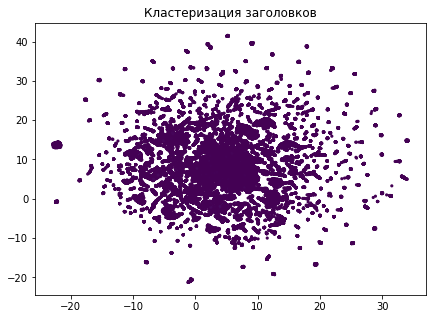

In [75]:
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = df.views[news_df.index],
s = 10, # size
edgecolor='none'
)
plt.title('UMAP проекция заголовков')
plt.show()

In [76]:
vectorizer = TfidfVectorizer(stop_words=stopwords,
                             max_features = 1000, # keep top 1000 terms
                             max_df = 0.5,
                             smooth_idf=True)
X = vectorizer.fit_transform(news_df['clean_text'])
X.shape # check shape of the document-term matrix

(113172, 1000)

In [77]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=21)

svd_model.fit(X)

len(svd_model.components_)

20

In [78]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print('Topic '+str(i)+':')
    for t in sorted_terms:
        print(t[0], end='')
        print(' ', end='')
    print('')

Topic 0:
млрд рублей банка банк россии годовых банки 
Topic 1:
рубля курс доллара официальный евро составил нефть 
Topic 2:
годовых проценты выплачиваются дней евро ежемесячно срока 
Topic 3:
индекс пункта фондовые торги отметке закрытия биржи 
Topic 4:
млрд банка банк капитал портфель кредитный нетто 
Topic 5:
нефть доллара баррель млрд цены котировки долларов 
Topic 6:
млрд долларов рублей году трлн евро объем 
Topic 7:
сбербанк сбербанка россии сказал акций глава заявил 
Topic 8:
сбербанк рублей сбербанка официальный доллара россии кредит 
Topic 9:
евро долларов сбербанк сбербанка компании карты долларах 
Topic 10:
ставка кредита ставки евро рубль эксперт карты 
Topic 11:
сбербанк сбербанка банка вкладов рейтинг россии капитала 
Topic 12:
долларов карты официальный карт банк году млрд 
Topic 13:
долларов официальный кредита ставка евро составляет кредит 
Topic 14:
компании компания осаго акций компаний мосбиржи страхования 
Topic 15:
официальный евро составляет компании году курс ос

In [79]:
X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=21).fit_transform(X_topics)

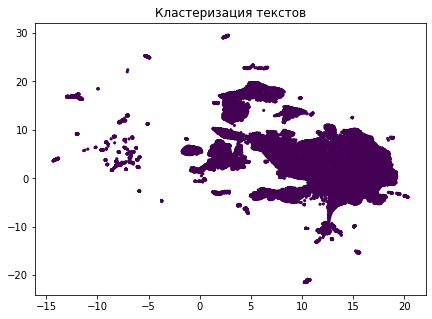

In [80]:
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = df.views[news_df.index],
s = 10, # size
edgecolor='none'
)
plt.title('UMAP проекция текстов')
plt.show()